In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


In [10]:
hit_data_scope_1081 = sf.DUT_TELE_merge(1081)

In [2]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
hit_data_scope_1093 = sf.DUT_TELE_merge(1093)

In [3]:
# gal_scope_1081 = sf.gal_scope_merge(1081)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


In [6]:
hit_data_1081 = rf.get_ROOT_data_zip_RECO(1081)

1081 RECONSTRUCTED finished


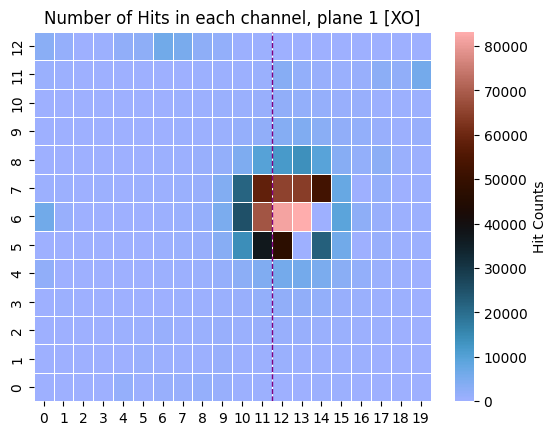

In [7]:
rf.hits_amount_colormap_single_plane(hit_data_1081,1)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

PAD RECONSTRUCTION

In [22]:
# add the reconstructed data of the dead pad to the hits data
def add_reconstruct_data_single_dead_pad(data, plane, pad, scope_data = True, only_reco_data = False):

    if scope_data:
        hit_data = data.hits

    # get the array of the reconstructed data
    reco_pad = rf.pads_reconstruct(hit_data, plane, pad)

    # turn empty data in the reconstructed results to zeros
    reco_amp = ak.fill_none(ak.firsts(reco_pad), 0.0)

    # zip the reconstructed data to plane and ch of dead pad
    reco_pad_plane_ch = ak.zip(
        {
            "plane": ak.full_like(reco_amp, plane, dtype="int32"),
            "ch":    ak.full_like(reco_amp, pad, dtype="int32"),
            "amp":   reco_amp,
        })

    # turn the reconstructed data into subarrays per event
    reco1 = ak.unflatten(reco_pad_plane_ch, 1)

    # turn all zeros to empty spaces
    keep = reco_amp != 0
    reco_to_add = ak.fill_none(ak.mask(reco1, keep), [])

    if only_reco_data:
        return reco_to_add

    # combine with original data
    hits_with_reco_pad = ak.concatenate([hit_data, reco_to_add], axis=1)

    data_with_reco_pad = ak.with_field(data, hits_with_reco_pad, "hits")

    return data_with_reco_pad

# reco_146_1093 = add_reconstruct_data_single_dead_pad(hit_data_scope_1093, 4, 146)

In [23]:
# reconstruct the dead channels around the shower in a run - radius of reco dtermines the distance from the center of the shower to be reconstructed
def reconstruct_data_all_dead_pads2(data, radius, path_to_diagnostics, number_of_planes = 8):

# find the center of the shower

    # single hit in the first plane
    first_plane1 = data.hits[data.hits.plane == 0]
    first_plane = first_plane1[ak.num(first_plane1) == 1]

    # ch activated in the first plane
    first_plane_ch = first_plane.ch

    # define center of the shower as the most activated pad in the first plane 
    counted_channels, counts = np.unique(ak.flatten(first_plane_ch), axis=0, return_counts=True)
    imax = np.argmax(counts)
    central_pad = counted_channels[imax]
    print("shower center:", central_pad)   
    



# get the dead channels list

    # list of all dead channels
    all_dead_channels = rf.channels_diagnostics(path_to_diagnostics, number_of_planes)
    print("amount of dead channels:", len(all_dead_channels))
    
    # get the pads in the wanted radius
    base = list(range(central_pad - radius, central_pad + radius +1))
    pads = [x + 20*i for i in range(-radius, radius+1) for x in base]
    
    # get the dead channels only from the wanted radius
    radius_mask = np.isin(all_dead_channels.channel_ID, pads)
    dead_channels_in_radius1 = all_dead_channels[radius_mask] 

    # delete dead channels starting at the first plane as we cant average for them
    dead_channels_in_radius = dead_channels_in_radius1[dead_channels_in_radius1.plane_ID > 0]


# add the reconstructed data
    reco_data_list = []
    counter = len(dead_channels_in_radius)
    for channel in dead_channels_in_radius:
        
        reco_data_to_add = add_reconstruct_data_single_dead_pad(data, channel.plane_ID, channel.channel_ID, only_reco_data=True)

        reco_data_list.append(reco_data_to_add)

        print(channel)
        counter -= 1
        print(counter, "channels left")
    
     # combine all channels' reco hits: N * (sum hits) * record
    reco_all = ak.concatenate(reco_data_list, axis=1)

    # append ONCE
    hits2 = ak.concatenate([data.hits, reco_all], axis=1)

    # put back into full data record
    data2 = ak.with_field(data, hits2, "hits")



    # counter = len(dead_channels_in_radius)
    # for channel in dead_channels_in_radius:
    #     data = add_reconstruct_data_single_dead_pad(data, channel.plane_ID, channel.channel_ID)
    #     print(channel)
    #     counter -= 1
    #     print(counter, "channels left")
    
    return data2

    # connect with the originial data
path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


# b = reconstruct_data_all_dead_pads2(hit_data_scope_1093, 2, path)


<>:74: SyntaxWarning: invalid escape sequence '\T'
<>:74: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_11520\4031925208.py:74: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


In [3]:
path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"
a = rf.reconstruct_data_all_dead_pads(hit_data_scope_1093, 2, path)
a

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_17480\1253213867.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


shower center: 124
we got the data
amount of dead channels: 140
{plane_ID: 2, channel_ID: 102}
3 channels left
{plane_ID: 2, channel_ID: 144}
2 channels left
{plane_ID: 4, channel_ID: 146}
1 channels left
{plane_ID: 6, channel_ID: 146}
0 channels left


<Array [{tele: [{...}], hits: [...]}, ...] type='440902 * {tele: var * {x: ...'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

GAP 1081

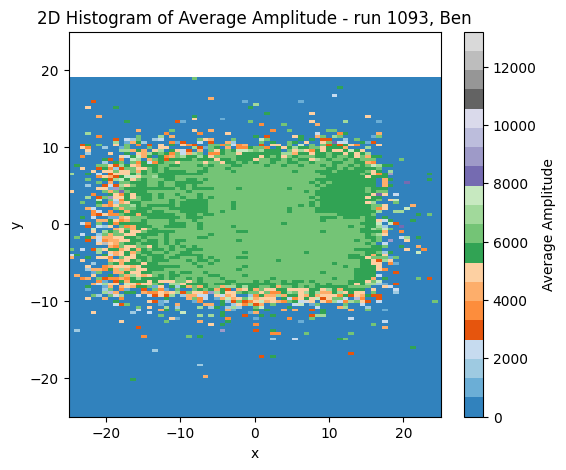

In [7]:
# xy_data = hit_data_scope_1093
xy_data = a
# xy_data = b


X_ben1 = ak.flatten(xy_data.tele.x)
Y_ben1 = ak.flatten(xy_data.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(xy_data.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# Define bins
bins = 300

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben, Y_ben, bins=bins, weights=amp_ben)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben, Y_ben, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
# plt.xlim(min(X_ben), max(X_ben))
plt.xlim(-25, 25)
# plt.ylim(min(Y_ben), max(Y_ben))
plt.ylim(-25, 25)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1093, Ben")
plt.show()


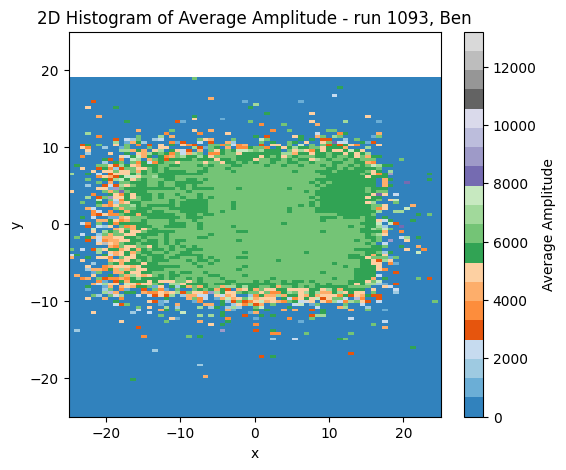

In [4]:
sf.avg_energy_scope_colormap(a, x_borders=25, y_borders=25)

In [ ]:
path = "TB_FIRE\TB_reco\TB_FIRE_1081_raw_reco_diagnostics.root"
hit_data_1081_reco_pads = reconstruct_data_all_dead_pads2(hit_data_scope_1081, 6, path)

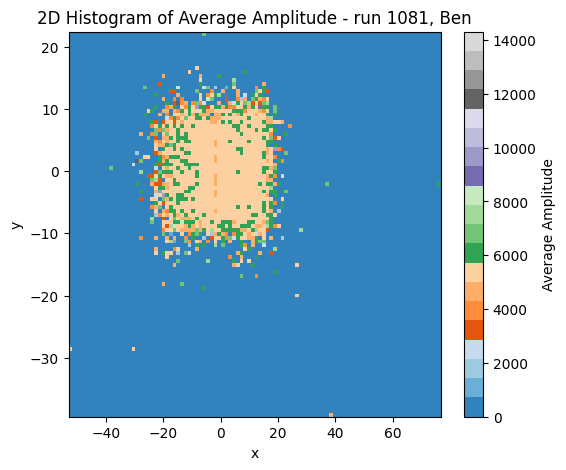

In [15]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 3)

data = hit_data_scope_1081
data = hit_data_1081_reco_pads
# data = hit_data_scope_1081_filtered

X_ben1 = ak.flatten(data.tele.x)
Y_ben1 = ak.flatten(data.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(data.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# mask = (X_ben > -10) & (X_ben < 10)
# mask = (amp_ben < 8000)
mask = amp_ben > 0
X_ben_mask = X_ben[mask]
Y_ben_mask = Y_ben[mask]
amp_ben_mask = amp_ben[mask]

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben_mask, Y_ben_mask, bins=bins, weights=amp_ben_mask)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben_mask, Y_ben_mask, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)


# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_ben_mask), max(X_ben_mask))
# plt.xlim(-30, 30)
plt.ylim(min(Y_ben_mask), max(Y_ben_mask))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Ben")
plt.show()


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_11520\2873674200.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1081_raw_reco_diagnostics.root"


shower center: 133
we got the data
amount of dead channels: 139
{plane_ID: 1, channel_ID: 77}
81 channels left
{plane_ID: 1, channel_ID: 133}
80 channels left
{plane_ID: 1, channel_ID: 239}
79 channels left
{plane_ID: 2, channel_ID: 19}
78 channels left
{plane_ID: 2, channel_ID: 32}
77 channels left
{plane_ID: 2, channel_ID: 50}
76 channels left
{plane_ID: 2, channel_ID: 54}
75 channels left
{plane_ID: 2, channel_ID: 67}
74 channels left
{plane_ID: 2, channel_ID: 77}
73 channels left
{plane_ID: 2, channel_ID: 138}
72 channels left
{plane_ID: 2, channel_ID: 148}
71 channels left
{plane_ID: 2, channel_ID: 172}
70 channels left
{plane_ID: 2, channel_ID: 173}
69 channels left
{plane_ID: 2, channel_ID: 174}
68 channels left
{plane_ID: 2, channel_ID: 175}
67 channels left
{plane_ID: 2, channel_ID: 176}
66 channels left
{plane_ID: 2, channel_ID: 178}
65 channels left
{plane_ID: 2, channel_ID: 179}
64 channels left
{plane_ID: 2, channel_ID: 192}
63 channels left
{plane_ID: 2, channel_ID: 193}


[5078, 5393, 5889, 6038, 6016, 5722, ..., 5091, 4709, 5183, 3284, 3678, 5307]
Gaussian fit parameters:
c     = 5491.511
m     = 0.159
theta     = 0.157 Radians
A     = 655.691
mu    = -2.333
sigma = 1.427
(np.float64(5489.129956846107), np.float64(5515.32368988845))


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


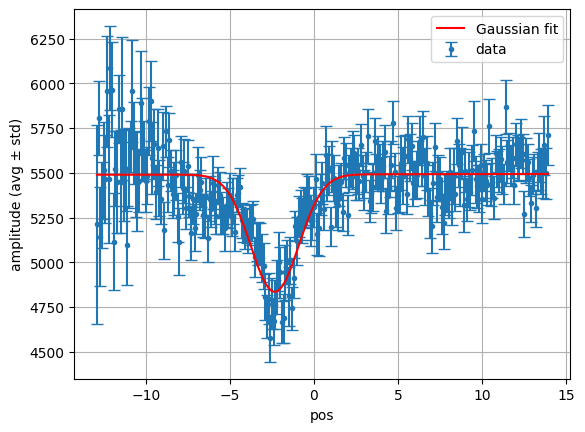

In [11]:
sf.E_vs_X_scope_gaussian_fit(hit_data_scope_1081, 0.5, -7, 3, -13, 14)

In [ ]:

tlu_ben = ak.firsts(hit_data_scope_1081_tlu.hits.TLU, axis = 1) 
tlu_gal = ak.firsts(gal_scope_1081.TLU)
gal_in_ben_mask = np.isin(tlu_gal,tlu_ben)
tlu_gal_in_ben = tlu_gal[~gal_in_ben_mask]

In [17]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]

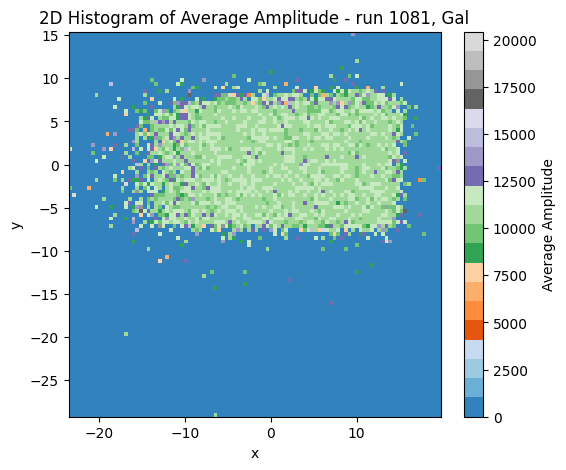

In [8]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]
X_gal1 = ak.mean(gal_ben_1081_scope.x_dut, axis=1)
Y_gal1 = ak.mean(gal_ben_1081_scope.y_dut, axis=1)

X_gal = -ak.to_numpy(X_gal1)
Y_gal = ak.to_numpy(Y_gal1)

amp_gal1 = ak.sum(gal_ben_1081_scope.Amplitudes, axis=1)
amp_gal = ak.to_numpy(amp_gal1)

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_gal, Y_gal, bins=bins, weights=amp_gal)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_gal, Y_gal, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_gal), max(X_gal))
# plt.xlim(-30, 30)
plt.ylim(min(Y_gal), max(Y_gal))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Gal")
plt.show()


[123, 124, 125, 126, 127, 143, 144, 145, 146, 147, 103, 104, 105, 106, 107]


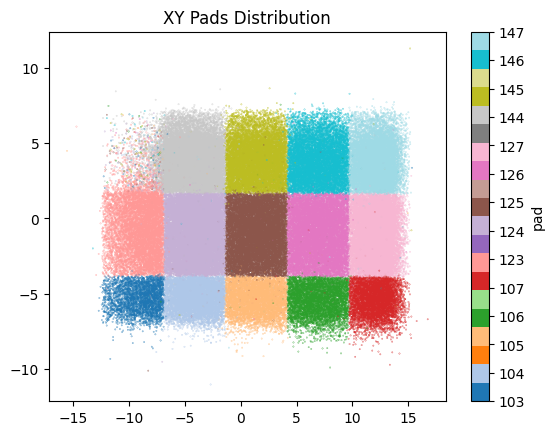

In [43]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 0.9) 
# chosen_pads = sf.pads_xy(hit_data_scope_1081_filtered, 135)
chosen_pads = sf.pads_xy(hit_data_scope_1093, 125)

[132, 133, 134, 135, 136, 152, 153, 154, 155, 156, 112, 113, 114, 115, 116]


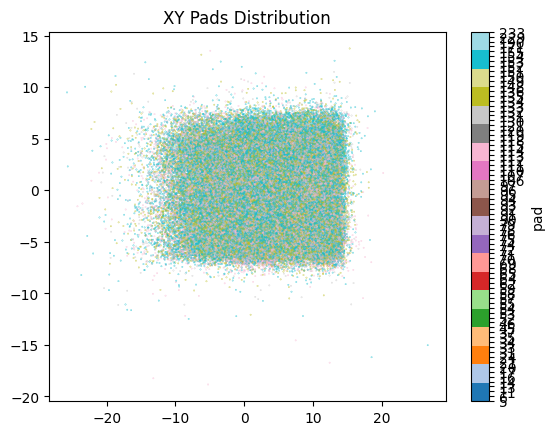

In [316]:
gal_scope_1081
gal_ch = gal_scope_1081.Channels
gal_planes = gal_scope_1081.Planes
gal_ch
gal_x = ak.firsts(gal_scope_1081.x_dut)
gal_y = ak.firsts(gal_scope_1081.y_dut)

hits = ak.zip({"plane": gal_planes, "ch": gal_ch})
gal_x = ak.singletons(gal_x)
gal_y = ak.singletons(gal_y)
tele = ak.zip({"x": gal_x, "y": gal_y})


gal_1081_xych = ak.zip({"hits": hits, "tele": tele}, depth_limit=1)
        


chosen_pads = pads_xy(gal_1081_xych, 134)